<a href="https://colab.research.google.com/github/LeeMooHeon/Final-Team10/blob/main/10%ED%8C%80_%EC%9D%B4%EB%AC%B4%ED%97%8C_%EC%9C%A0%EC%A0%80_%EA%B8%B0%EB%B0%98_%EA%B0%80%EC%84%A41.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
import pandas as pd

links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
'''

"\nimport pandas as pd\n\nlinks = pd.read_csv('links.csv')\nmovies = pd.read_csv('movies.csv')\nratings = pd.read_csv('ratings.csv')\ntags = pd.read_csv('tags.csv')\n"

# **한글**

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] =False


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

# **데이터 불러오기 및 전처리**

In [ ]:
from google.colab import drive
import pandas as pd

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 데이터 불러오기
base_path = "/content/drive/MyDrive"

links = pd.read_csv(f"{base_path}/links.csv")
movies = pd.read_csv(f"{base_path}/movies.csv")
ratings = pd.read_csv(f"{base_path}/ratings.csv")
tags = pd.read_csv(f"{base_path}/tags.csv")



# 확인
#print(links.shape, movies.shape, ratings.shape, tags.shape)
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# ratings, tags의 timestamp를 datetime으로 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

# 2020년 1월 1일 이후 데이터만 추출
cutoff_date = pd.Timestamp('2020-01-01')
ratings = ratings[ratings['timestamp'] >= cutoff_date].copy()
tags = tags[tags['timestamp'] >= cutoff_date].copy()

# movies, links도 ratings 기준으로 필터링
movie_ids = ratings['movieId'].unique()
movies = movies[movies['movieId'].isin(movie_ids)].copy()
links = links[links['movieId'].isin(movie_ids)].copy()



# 확인
print("ratings shape:", ratings.shape)
#print("tags shape:", tags.shape)
#print("movies shape:", movies.shape)
#print("links shape:", links.shape)


ratings shape: (4635230, 4)


In [ ]:
import numpy as np
# 영화 개봉연도 추출
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# 콘텐츠 연령 계산
ratings = ratings.merge(movies[['movieId','release_year']], on='movieId', how='left')
ratings['rating_year'] = ratings['timestamp'].dt.year
ratings['content_age'] = ratings['rating_year'] - ratings['release_year']

# 유저별 평균 콘텐츠 연령
user_age_pref = ratings.groupby('userId')['content_age'].mean().reset_index()
median_age = user_age_pref['content_age'].median()

# 트렌드 vs 레트로 성향
user_age_pref['age_pref'] = np.where(
    user_age_pref['content_age'] >= median_age, "retro", "trend"
)

# 유저 성향 합치기
ratings = ratings.merge(user_age_pref[['userId','age_pref']], on='userId', how='left')


# **Heavy Rater 설정**

In [ ]:
import numpy as np
import pandas as pd

# Heavy / Other 유저 분리
user_stats = ratings.groupby("userId").agg(
    rating_count=("rating", "count"),
    avg_rating=("rating", "mean")
).reset_index()

threshold = user_stats["rating_count"].quantile(0.9)

heavy_raters = set(user_stats.loc[user_stats["rating_count"] >= threshold, "userId"])

# Ratings 분리
ratings["group"] = np.where(ratings["userId"].isin(heavy_raters), "heavy", "other")

heavy_ratings = ratings[ratings["group"]=="heavy"]
other_ratings = ratings[ratings["group"]=="other"]


In [ ]:
print("헤비레이터 수:", len(heavy_raters))
print("전체 유저 수:", user_stats["userId"].nunique())
print("비율: {:.2f}%".format(len(heavy_raters) / user_stats["userId"].nunique() * 100))


헤비레이터 수: 2937
전체 유저 수: 29346
비율: 10.01%


# **Heavy** vs **Others t_test, 기초 시각화**

In [ ]:
from scipy.stats import ttest_ind, ttest_rel

t_stat, p_val = ttest_ind(heavy_ratings["rating"], other_ratings["rating"], equal_var=False)

print("[독립 t-검정]")
print("t-statistic:", t_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("=> 두 그룹 간 차이가 통계적으로 유의함 (p < 0.05)")
else:
    print("=> 두 그룹 간 차이가 통계적으로 유의하지 않음 (p >= 0.05)")

# =====================================
# 3) 대응표본 t-검정 (같은 영화 기준 평균 비교)
# =====================================
movie_avg_stats = (
    ratings.groupby(["movieId","group"])["rating"].mean()
    .unstack()
    .dropna()
)

t_stat, p_val = ttest_rel(movie_avg_stats["heavy"], movie_avg_stats["other"])

print("\n[대응 t-검정]")
print("t-statistic:", t_stat)
print("p-value:", p_val)
if p_val < 0.05:
    print("=> 영화별 Heavy vs Other 평균 차이가 통계적으로 유의함 (p < 0.05)")
else:
    print("=> 영화별 Heavy vs Other 평균 차이가 통계적으로 유의하지 않음 (p >= 0.05)")

[독립 t-검정]
t-statistic: -493.8215057743266
p-value: 0.0
=> 두 그룹 간 차이가 통계적으로 유의함 (p < 0.05)

[대응 t-검정]
t-statistic: -79.74685156438002
p-value: 0.0
=> 영화별 Heavy vs Other 평균 차이가 통계적으로 유의함 (p < 0.05)


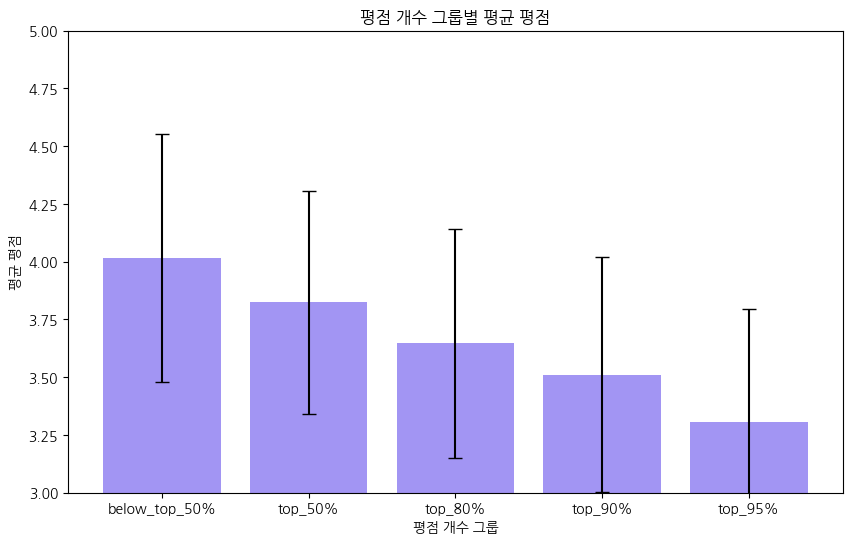

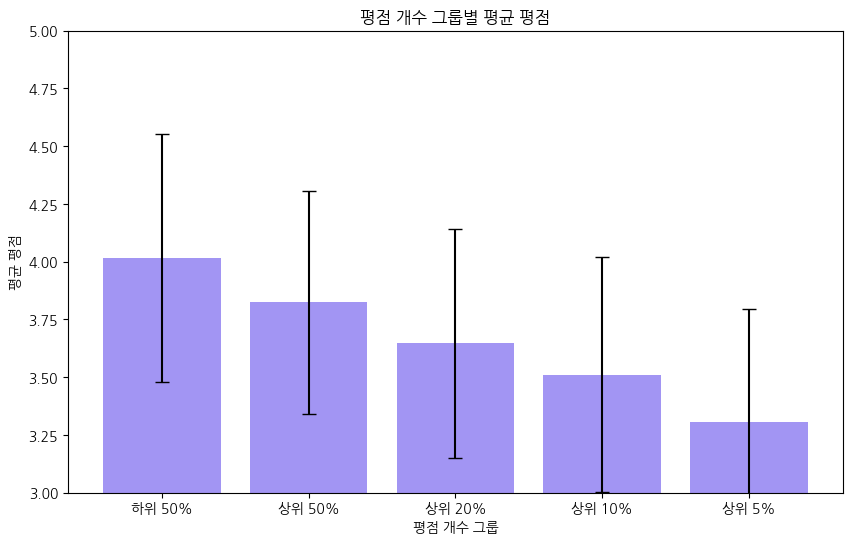

In [ ]:
import matplotlib.pyplot as plt



# 평점 개수 기준 그룹 설정
percentiles = [50, 80, 90, 95]  # 상위 % 기준
thresholds = np.percentile(user_stats["rating_count"], percentiles)

def assign_group(r):
    # 높은 퍼센트 순서로 체크
    for p_val, p in zip(thresholds[::-1], percentiles[::-1]):
        if r >= p_val:
            return f"top_{p}%"
    return f"below_top_{percentiles[0]}%"

user_stats["rating_group"] = user_stats["rating_count"].apply(assign_group)



# 그룹별 평균과 표준편차 계산

group_stats = user_stats.groupby("rating_group")["avg_rating"].agg(['mean','std']).reindex(
    ["below_top_50%", "top_50%", "top_80%", "top_90%", "top_95%"]
).reset_index()


# 막대그래프 그리기
plt.figure(figsize=(10,6))
plt.bar(group_stats["rating_group"], group_stats["mean"], yerr=group_stats["std"],
        capsize=5, color='mediumslateblue', alpha=0.7)
plt.title("평점 개수 그룹별 평균 평점")
plt.xlabel("평점 개수 그룹")
plt.ylabel("평균 평점")
plt.ylim(3, 5)  # 평점 범위
plt.show()
import matplotlib.pyplot as plt

# 막대그래프 그리기
plt.figure(figsize=(10,6))
plt.bar(group_stats["rating_group"], group_stats["mean"],
        yerr=group_stats["std"], capsize=5,
        color='mediumslateblue', alpha=0.7)

plt.title("평점 개수 그룹별 평균 평점")
plt.xlabel("평점 개수 그룹")
plt.ylabel("평균 평점")
plt.ylim(3, 5)  # 평점 범위

# 원하는 한글 라벨 지정
new_labels = ["하위 50%", "상위 50%", "상위 20%", "상위 10%", "상위 5%"]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)

plt.show()



# **영화별 Heavy, Other 평점 집계, Top 10 확인**

In [ ]:
# 영화별 heavy / other 평균 & 개수 집계
rating_stats = (
    ratings.groupby(["movieId", "group"])
    .agg(avg_rating=("rating", "mean"), count=("rating", "size"))
    .reset_index()
)

# wide 형태 변환
rating_stats = rating_stats.pivot(index="movieId", columns="group", values=["avg_rating", "count"])
rating_stats.columns = ["heavy_avg", "other_avg", "heavy_count", "other_count"]
rating_stats = rating_stats.reset_index()

# total_count 계산
rating_stats["total_count"] = rating_stats["heavy_count"] + rating_stats["other_count"]


In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)  # 모든 컬럼 표시
pd.set_option("display.width", 2000)        # 한 줄에 표시할 폭 늘리기
pd.set_option("display.max_colwidth", None) # 문자열 잘림 방지


In [ ]:
# 평점 개수 Top10 영화 추출 + title merge
top10_movies = rating_stats.nlargest(10, "total_count").merge(
    movies[["movieId", "title"]], on="movieId", how="left"
)

result = top10_movies[["title", "heavy_avg", "other_avg", "heavy_count", "other_count", "total_count"]]

print(result)

                                                       title  heavy_avg  other_avg  heavy_count  other_count  total_count
0                                           Inception (2010)   4.018739   4.188937       2268.0      12835.0      15103.0
1                                         Matrix, The (1999)   4.163539   4.169744       2238.0      11535.0      13773.0
2                                    Dark Knight, The (2008)   4.129169   4.206506       2249.0      11312.0      13561.0
3                           Shawshank Redemption, The (1994)   4.248196   4.361357       2079.0      11187.0      13266.0
4                                          Fight Club (1999)   4.167288   4.235843       2146.0      10560.0      12706.0
5                                        Interstellar (2014)   3.981429   4.243145       2100.0      10175.0      12275.0
6  Lord of the Rings: The Fellowship of the Ring, The (2001)   4.070363   4.093695       2146.0       9659.0      11805.0
7      Lord of the Rings

# **Real, Heavy, Weighted Top3**

In [ ]:
# 실제 전체 평균 (real_avg)
result["real_avg"] = (
    result["heavy_avg"] * result["heavy_count"] +
    result["other_avg"] * result["other_count"]
) / result["total_count"]

# 가중 평균 (Heavy 영향 확대)
result["weighted_avg"] = (
    result["heavy_avg"] * result["other_count"] +
    result["other_avg"] * result["heavy_count"]
) / result["total_count"]

# 가중평균과 실제평균 차이
result["weighted_diff"] = result["weighted_avg"] - result["real_avg"]

# diff (Heavy - Other)
result["diff"] = result["heavy_avg"] - result["other_avg"]

# 필요한 컬럼 정리
display(result[[
    "title", "heavy_avg", "other_avg", "diff",
    "real_avg", "weighted_avg", "weighted_diff"
]])


,title,heavy_avg,other_avg,diff,real_avg,weighted_avg,weighted_diff
0,Inception (2010),4.018739,4.188937,-0.170198,4.163378,4.044297,-0.119081
1,"Matrix, The (1999)",4.163539,4.169744,-0.006205,4.168736,4.164547,-0.004189
2,"Dark Knight, The (2008)",4.129169,4.206506,-0.077338,4.193680,4.141994,-0.051686
3,"Shawshank Redemption, The (1994)",4.248196,4.361357,-0.113161,4.343623,4.265930,-0.077692
4,Fight Club (1999),4.167288,4.235843,-0.068555,4.224264,4.178867,-0.045397
5,Interstellar (2014),3.981429,4.243145,-0.261716,4.198371,4.026203,-0.172168
6,"Lord of the Rings: The Fellowship of the Ring, The (2001)",4.070363,4.093695,-0.023332,4.089454,4.074605,-0.014849
7,"Lord of the Rings: The Return of the King, The (2003)",4.072762,4.121828,-0.049066,4.112889,4.081701,-0.031189
8,"Lord of the Rings: The Two Towers, The (2002)",4.034069,4.099294,-0.065225,4.087107,4.046257,-0.040850
9,Parasite (2019),4.207499,4.338957,-0.131458,4.315471,4.230985,-0.084486


In [ ]:
# 평점 개수 Top3 영화 추출 + title merge
top3_movies = rating_stats.nlargest(3, "total_count").merge(
    movies[["movieId", "title"]], on="movieId", how="left"
)

result_1 = top3_movies[["title", "heavy_avg", "other_avg", "heavy_count", "other_count", "total_count"]]

result_1["real_avg"] = (
    result_1["heavy_avg"] * result_1["heavy_count"] +
    result_1["other_avg"] * result_1["other_count"]
) / result_1["total_count"]

print(result_1)

                     title  heavy_avg  other_avg  heavy_count  other_count  total_count  real_avg
0         Inception (2010)   4.018739   4.188937       2268.0      12835.0      15103.0  4.163378
1       Matrix, The (1999)   4.163539   4.169744       2238.0      11535.0      13773.0  4.168736
2  Dark Knight, The (2008)   4.129169   4.206506       2249.0      11312.0      13561.0  4.193680


In [ ]:
# 가중 평균 (Heavy 영향 확대)
result_1["weighted_avg"] = (
    result_1["heavy_avg"] * result_1["heavy_count"] +
    result_1["other_avg"] * result_1["other_count"]
) / result_1["total_count"]

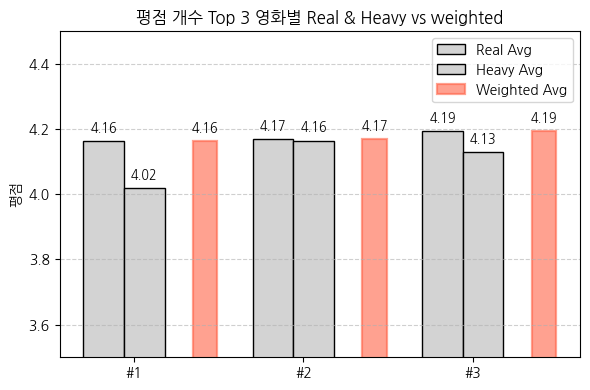

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
x = np.arange(len(result_1))
w = 0.24

# Real·Heavy: 붙임
plt.bar(x - w/2, result_1["real_avg"],  w, label="Real Avg",
        color="lightgray", edgecolor="black", alpha=1)
plt.bar(x + w/2, result_1["heavy_avg"], w, label="Heavy Avg",
        color="lightgray", edgecolor="black", alpha=1)

# Opt: 얇게 + 진한 테두리 + 살짝 투명
plt.bar(x + w*2.0, result_1["weighted_avg"], w*0.6,
        label="Weighted Avg", color="tomato", edgecolor="tomato", linewidth=1.6, alpha=0.6)

# 값 라벨
for i in x:
    plt.text(i - w/2, result_1["real_avg"].iloc[i] + 0.02, f'{result_1["real_avg"].iloc[i]:.2f}',
             ha='center', va='bottom', fontsize=9)
    plt.text(i + w/2, result_1["heavy_avg"].iloc[i] + 0.02, f'{result_1["heavy_avg"].iloc[i]:.2f}',
             ha='center', va='bottom', fontsize=9)
    plt.text(i + w*2.0, result_1["weighted_avg"].iloc[i] + 0.02, f'{result_1["weighted_avg"].iloc[i]:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.xticks(x + w*0.25, [f"#{i+1}" for i in range(len(result_1))])
plt.ylabel("평점")
plt.title("평점 개수 Top 3 영화별 Real & Heavy vs weighted")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.ylim(3.5, 4.5)
plt.legend()
plt.tight_layout()
plt.show()
